In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from thermography_dataset import ThermDataset
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Parameters 

In [2]:
args = {'main lr':0.01,
        'nested lr':0.001,
        'batch_size':32,
        'main epochs':500,
        'pretrain epochs': 500,
        'noise':0,
        'train_size':0.7,
        }

# Prepare Data

In [3]:
dataset = ThermDataset(fp='combined_data.xlsx', direction=0, noise_scale=args['noise'], tandem=1)

In [4]:
train_size = int(args['train_size'] * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
nested_loader = DataLoader(dataset, shuffle=True, batch_size=args['batch_size'])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'])
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=args['batch_size'])

# Design Model 
(input size, output size, forward pass)

In [6]:
# temp in spec out
class SubNN(nn.Module):
    def __init__(self, spec_size, temp_size):
        super(SubNN, self).__init__()
        self.lin1 = nn.Linear(temp_size, 45)
        self.lin2 = nn.Linear(45, 60)
        self.lin3 = nn.Linear(60, 75)
        self.lin4 = nn.Linear(75, 60)
        self.lin_fin = nn.Linear(60, spec_size)


    def forward(self, x):
        spec_pred = F.leaky_relu(self.lin1(x))
        spec_pred = F.leaky_relu(self.lin2(spec_pred))
        spec_pred = F.leaky_relu(self.lin3(spec_pred))
        spec_pred = F.leaky_relu(self.lin4(spec_pred))
        spec_pred = self.lin_fin(spec_pred)
        return spec_pred

In [7]:
# spec in spec out
class MainNN(nn.Module):
    def __init__(self, temp_size, spec_size):
        super(MainNN, self).__init__()
        self.subnet = SubNN(spec_size=spec_size, temp_size=temp_size) # temp in spec out
        self.lin1 = nn.Linear(spec_size, 45) 
        self.lin2 = nn.Linear(45, 45)
        self.lin3 = nn.Linear(45, 45)
        self.lin_fin = nn.Linear(45, temp_size)

    def forward(self, x):
        temp_pred = F.leaky_relu(self.lin1(x))
        temp_pred = F.leaky_relu(self.lin2(temp_pred))
        temp_pred = F.leaky_relu(self.lin3(temp_pred))
        temp_pred = self.lin_fin(temp_pred)
        
        spec_pred = self.subnet(temp_pred)

        return spec_pred, temp_pred

In [8]:
n_samples = len(train_dataset)
_, temp_size = dataset.x.shape
_, spec_size = dataset.y.shape

main_model = MainNN(temp_size=temp_size, spec_size=spec_size)
nested_model = SubNN(temp_size=temp_size, spec_size=spec_size)

# Construct Loss and Optimizer

In [9]:
nested_learning_rate = args['nested lr']
main_learning_rate = args['main lr']
criterion = nn.MSELoss()
main_optimizer = torch.optim.Rprop(main_model.parameters(), lr=main_learning_rate)
nested_optimizer = torch.optim.Rprop(nested_model.parameters(), lr=nested_learning_rate)

# Training Loop

In [10]:
# pretrain loop
num_epochs = args['pretrain epochs']
loss_list = []
best_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    for temp_batch, spec_batch in train_loader:
        # empty gradients
        nested_optimizer.zero_grad()
        
        # forward pass and loss
        spec_pred = nested_model(temp_batch)
        loss = criterion(spec_pred, spec_batch)

        # backward pass
        loss.backward()

        # update
        nested_optimizer.step()


    loss_list.append(loss.item())

    if loss < best_loss:
        best_loss = loss
        best_epoch = epoch+1

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss}')

print(f'\nbest loss: {best_loss} in epoch: {best_epoch}')

epoch: 50, loss = 0.03611689805984497
epoch: 100, loss = 0.036025963723659515
epoch: 150, loss = 0.07336001098155975
epoch: 200, loss = 0.09071695804595947
epoch: 250, loss = 0.17088226974010468
epoch: 300, loss = 0.03593193739652634
epoch: 350, loss = 0.1812189668416977
epoch: 400, loss = 0.35314270853996277
epoch: 450, loss = 0.059333112090826035
epoch: 500, loss = 0.05538295954465866

best loss: 0.0077877352014184 in epoch: 392


In [11]:
# freeze weights
for param in main_model.subnet.parameters():
    param.requires_grad = False

In [12]:
# main loop
num_epochs = args['main epochs']
loss_list = []
temp_loss_list = []
tand_loss_list = []
best_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    for temp_batch, spec_batch in train_loader:        
        # empty gradients
        main_optimizer.zero_grad()

        # forward pass and loss
        spec_pred, temp_pred = main_model(spec_batch)

        # get loss
        tand_loss = criterion(spec_pred, spec_batch)
        temp_loss = criterion(temp_pred, temp_batch)
        total_loss = tand_loss + temp_loss

        # backward pass
        total_loss.backward()

        # update
        main_optimizer.step()

        

    loss_list.append(temp_loss.item())
    tand_loss_list.append(tand_loss.item())
    temp_loss_list.append(temp_loss.item())

    if temp_loss < best_loss:
        best_loss = temp_loss
        best_epoch = epoch+1

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, tandem loss = {tand_loss:.6f}, temperature loss = {temp_loss:.6f}')

print(f'\nbest temperature loss: {best_loss:.3f} in epoch: {best_epoch}')

epoch: 50, tandem loss = 24.627598, temperature loss = 222.063339
epoch: 100, tandem loss = 25.011101, temperature loss = 192.859390
epoch: 150, tandem loss = 26.585218, temperature loss = 253.774765
epoch: 200, tandem loss = 24.566442, temperature loss = 338.924408
epoch: 250, tandem loss = 22.631971, temperature loss = 182.446884
epoch: 300, tandem loss = 20.645407, temperature loss = 221.045074
epoch: 350, tandem loss = 20.806814, temperature loss = 240.979736
epoch: 400, tandem loss = 22.469353, temperature loss = 177.884781
epoch: 450, tandem loss = 21.827290, temperature loss = 199.734711
epoch: 500, tandem loss = 23.458811, temperature loss = 240.691360

best temperature loss: 75.287 in epoch: 163


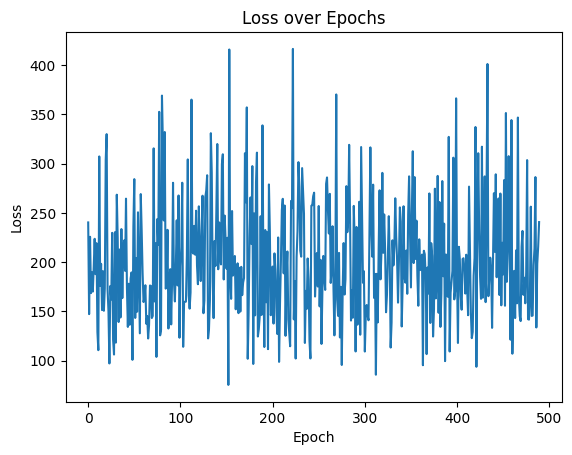

In [13]:
#plt.plot(loss_list, label='total loss')
#plt.plot(spec_loss_list[20:], label='spectrum loss')
plt.plot(temp_loss_list[10:], label='temperature loss')

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Testing

In [14]:
class IndividualFeatureLoss(nn.Module):
    def __init__(self, num_features):
        super(IndividualFeatureLoss, self).__init__()
        self.num_features = num_features
        self.loss_fn = nn.MSELoss()

    def forward(self, predicted, target):
        feature_losses = []
        for i in range(self.num_features):
            feature_pred = predicted[:, i]
            feature_target = target[:, i]
            feature_loss = self.loss_fn(feature_pred, feature_target)
            feature_losses.append(feature_loss)
        return feature_losses

In [15]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual, index, prediction):
    actual_np = actual[index]
    pred_np = pred[index]

    if prediction == 'spec':
        plt.title("Thermel-Emission Spectrum")
        plt.xlabel("Wavlength (m)")
        plt.ylabel("Intensity")
        pred_np = pred_np * (10**-12)
        actual_np = actual_np * (10**-12)
        wavelengths = dataset.wavelengths * (10**-3)
        plt.plot(wavelengths, actual_np, label='actual')
        plt.plot(wavelengths, pred_np, 'r+', label='predicted')
    else:
        plt.title("Temperature Distribution")
        plt.xlabel("Layer")
        plt.ylabel("Temperature (K)")
        x = np.arange(1, 12, 1)
        plt.plot(x, actual_np, label='actual')
        plt.plot(x, pred_np, 'r+', label='predicted')
        plt.xticks(np.arange(min(x), max(x)+1, 1.0))

    

    plt.legend()
    plt.show()

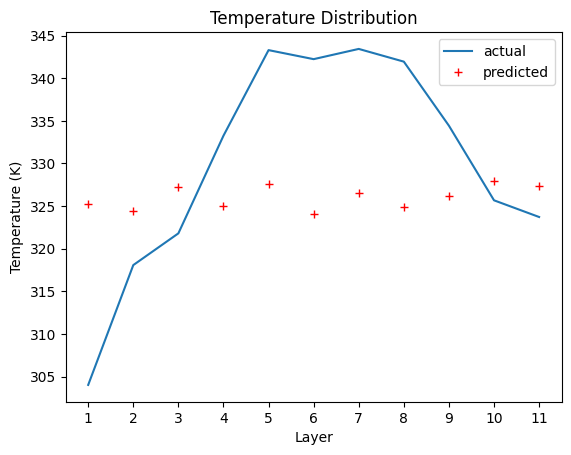

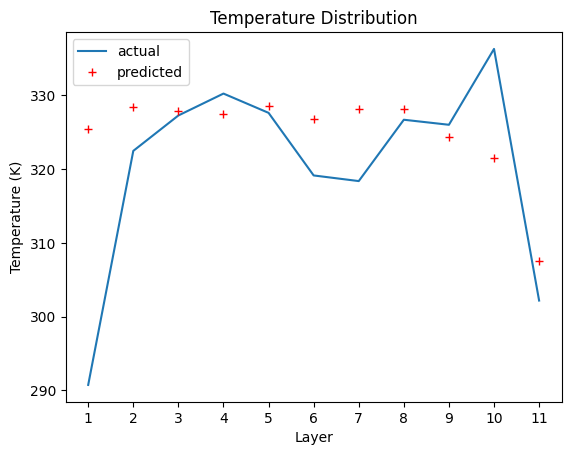

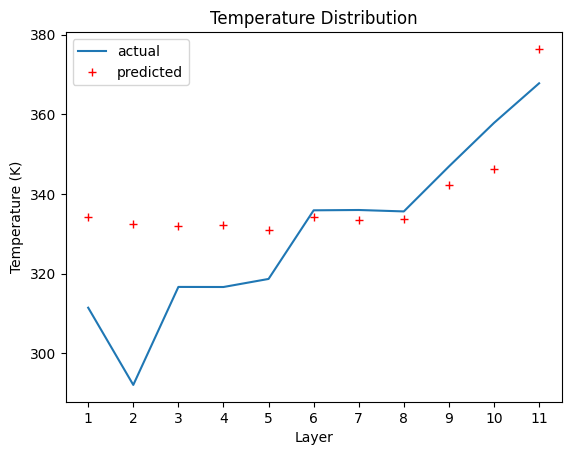

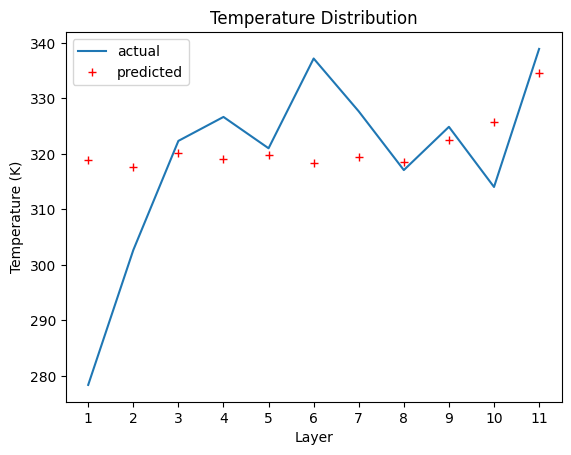

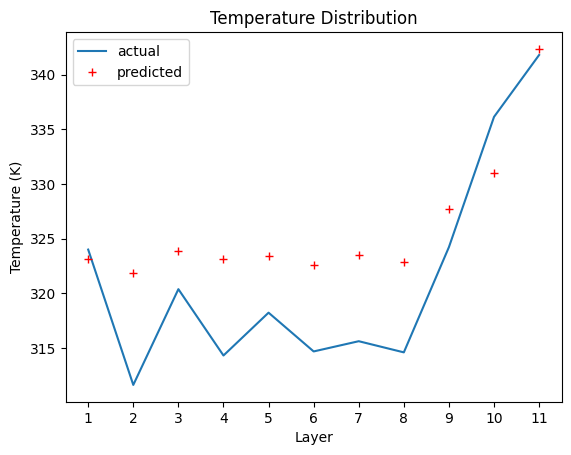

average temperature loss: 206.807
average spectrum loss: 22.612454
Average loss per layer:

[196.0, 72.0, 40.0, 38.0, 41.0, 34.0, 24.0, 19.0, 14.0, 22.0, 8.0]


In [16]:
total_temp_loss = 0
total_spec_loss = 0
total_layer_loss = [0] * 11
n_samples = 0
total_batches = len(test_loader)
current_batch = 0

loss_fn = IndividualFeatureLoss(11)

with torch.no_grad():
    for temp_batch, spec_batch in test_loader:
        spec_pred, temp_pred = main_model(spec_batch)
        
        temp_loss = criterion(temp_pred, temp_batch)
        total_temp_loss += temp_loss.item() * len(temp_batch)

        spec_loss = criterion(spec_pred, spec_batch)
        total_spec_loss += spec_loss.item() * len(spec_batch)

        n_samples += len(temp_batch)
        current_batch += 1

        if current_batch % int(total_batches/5) == 0:
            plot_actual_vs_pred(temp_pred.numpy(), temp_batch.numpy(), 0, prediction='temp')
            feature_losses = loss_fn(temp_pred, temp_batch)
            
            for i in range(11):
                total_layer_loss[i] += feature_losses[i].item()

            #plot_actual_vs_pred(spec_pred.numpy(), spec_batch.numpy(), 0, prediction='spec')

average_layer_loss = [x//total_batches for x in total_layer_loss]
average_temp_loss = total_temp_loss/n_samples
average_spec_loss = total_spec_loss/n_samples
print(f"average temperature loss: {average_temp_loss:.3f}\naverage spectrum loss: {average_spec_loss:.6f}")
print("Average loss per layer:\n")
print(average_layer_loss)